In [6]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
source_vertices = torch.tensor([[1.,3.],[5.,5.],[8., 3.]])
target_vertices = torch.tensor([[1.,5.],[5.,4.],[8., 5.]])
nb_pts = [10,4]

data = regdata.part_rigid(source_vertices, target_vertices, nb_pts)
data.build_source()
data.build_target()
data.build_modules()
source = data.source
target = data.target

In [8]:
data.modules

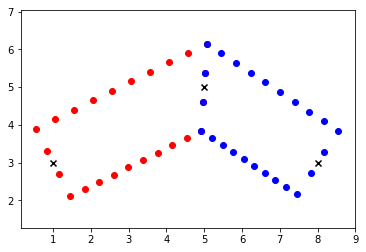

In [9]:
# Visualization of the source shape
# The shape is defined by the points at the black crosses

x = data.source[0].clone()
y = data.source[1].clone()

plt.figure()
plt.scatter(x[:, 0].detach().numpy(), x[:, 1].detach().numpy(), c='red')
plt.scatter(y[:, 0].detach().numpy(), y[:, 1].detach().numpy(), c='blue')
plt.scatter(source_vertices[:, 0].detach().numpy(), source_vertices[:, 1].detach().numpy(), c='k', marker='x')

plt.axis('equal')
plt.show()

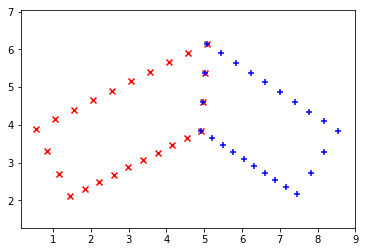

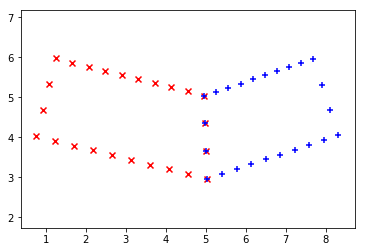

In [10]:
# Visualization of the source and target
plt.figure()
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red', marker='x')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue', marker='+')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red', marker='x')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue', marker='+')



plt.axis('equal')
plt.show()

In [11]:
# Definition of the multi shape module and Hamiltonian
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]])
modules.fill_controls_zero()
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [14]:
modules.module_list[-1].manifold.gd

[tensor([4.9282, 3.8460, 5.0718, 6.1540, 5.0239, 5.3847, 4.9761, 4.6153],
        grad_fn=<CloneBackward>),
 tensor([4.9282, 3.8460, 5.0718, 6.1540, 5.0239, 5.3847, 4.9761, 4.6153],
        grad_fn=<CloneBackward>)]

In [6]:
# Definition of the similarity metric
from defmod.attachement import L2NormAttachement

def attach(modules, target):
    return sum([L2NormAttachement()( modules.module_list[i][-1].manifold.gd.view(-1,2), target[i]) for i in range(len(target))])

In [10]:
constr_Id(modules)

tensor([[ 0.0031,  0.0461],
        [-0.0502,  0.0437],
        [-0.0325,  0.0447],
        [-0.0147,  0.0455],
        [ 0.0032, -0.0365],
        [-0.0517, -0.0384],
        [-0.0335, -0.0377],
        [-0.0152, -0.0371]], grad_fn=<CatBackward>)

In [9]:
# setting parameters for optimization
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id,source, target, 2, reg_param, attach)

# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional, X)

energy: constraints_________________
tensor([[ 0.0036,  0.0458],
        [-0.0495,  0.0484],
        [-0.0320,  0.0477],
        [-0.0142,  0.0468],
        [ 0.0037, -0.0368],
        [-0.0511, -0.0338],
        [-0.0330, -0.0347],
        [-0.0147, -0.0357]], grad_fn=<CatBackward>)
cost: 0.00200015509039 attach: 12.361446138251136
 iter : 0  ,total energy: 12.363446293341523
energy: constraints_________________
tensor([[ 0.0036,  0.0458],
        [-0.0495,  0.0484],
        [-0.0320,  0.0477],
        [-0.0142,  0.0468],
        [ 0.0037, -0.0368],
        [-0.0511, -0.0338],
        [-0.0330, -0.0347],
        [-0.0147, -0.0357]], grad_fn=<CatBackward>)
cost: 0.00200015509039 attach: 12.361446138251136
energy: constraints_________________
tensor([[ 0.0036,  0.0458],
        [-0.0495,  0.0484],
        [-0.0320,  0.0477],
        [-0.0142,  0.0468],
        [ 0.0037, -0.0368],
        [-0.0511, -0.0338],
        [-0.0330, -0.0347],
        [-0.0147, -0.0357]], grad_fn=<CatBackward>)


cost: 0.00199690390529 attach: 12.362982061399665
Condition 0: tensor(1, dtype=torch.uint8)
Condition 1, 2, 3: tensor(1, dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
Contition 4: tensor(0, dtype=torch.uint8)
Condition 5: False
c 4
 iter : 8  ,total energy: 12.36497896530495
energy: constraints_________________
tensor([[ 0.0036,  0.0458],
        [-0.0495,  0.0484],
        [-0.0320,  0.0477],
        [-0.0142,  0.0468],
        [ 0.0037, -0.0368],
        [-0.0511, -0.0338],
        [-0.0330, -0.0347],
        [-0.0147, -0.0357]], grad_fn=<CatBackward>)
cost: 0.00199951300793 attach: 12.360868327690003
energy: constraints_________________
tensor([[ 0.0036,  0.0458],
        [-0.0495,  0.0484],
        [-0.0320,  0.0477],
        [-0.0142,  0.0468],
        [ 0.0037, -0.0368],
        [-0.0511, -0.0338],
        [-0.0330, -0.0347],
        [-0.0147, -0.0357]], grad_fn=<CatBackward>)
cost: 0.00200001647031 attach: 12.362432648075467
Condition 0: tensor(1, 

In [ ]:
%matplotlib qt5
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

plt.figure()
for s,c in zip(states, colors):
    plt.scatter(s[0][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[0][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][-1].gd.view(-1,2)[:, 0].detach().numpy(), s[1][-1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()


In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):

        return model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param).energy_tensor(gd, mom)
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = mom0_tensor


test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_shooting():
    def shooting(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        
        intermediate_states, intermediate_controls = dm.shooting.shoot_euler(H, it=2)
        return H.module.manifold.unroll_cotan()
    return torch.autograd.gradcheck(shooting, (gd, mom), raise_exception=True,atol=1e-2)

test_gradcheck_shooting()

In [ ]:
def test_gradcheck_attachement():
    def attach(gd, mom):
        reg_param = 10**-3 

        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        energyfunc = model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param)

        return energyfunc.attach() 
    return torch.autograd.gradcheck(attach, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_attachement()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.module.compute_geodesic_variables(constr_Id)
        return H.module.controls[0]
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        return mod.autoaction()
    return torch.autograd.gradcheck(autoaction, (gd, mom), raise_exception=True)

mod = data.modules[0].copy()
gd = torch.cat(mod.manifold.gd.copy())
mom = torch.cat(mod.manifold.cotan.copy())

gd.requires_grad
mom.requires_grad

test_gradcheck_autoaction()

In [ ]:
modules.module_list[-1].autoaction()

In [ ]:
modules.background.costop_inv()

In [ ]:
torch.inverse(modules.background.K_q())

In [ ]:
modules.background.K_q() #- torch.eye(20)